In [78]:
%run 2gis_functions.ipynb

Ready: 2023-03-30 01:11:00


In [60]:
findspark.init()
from pyspark.sql import SparkSession
try:
    spark.stop()
except:
    pass
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()
spark

# Новосибирск

In [143]:
name = 'novosib'
rubrics = pd.read_excel(r"C:\Users\Mamed\YandexDisk\_Documents\Проекты\2ГИС 2023\Backups\_Final\Мастер_таблица_2ГИС_Новосибирск_230322_2345.xlsx")[['Рубрика']].iloc[:70]

df = spark.read.parquet(f'df_filtered_{name}')
df.createOrReplaceTempView('df')

In [210]:
df_new = spark.sql('''

select 
rubricName
, time
, year(time) year_r
, hour(time) hour_r
, SUBSTR(time, 6, 5) date_r
, case when weekofyear(time) > 9 then 1 else weekofyear(time) end week_r
, case when extract(dayofweek from time) = 1 then 7
    else extract(dayofweek from time)-1
end week_day_r

from df
''')

df_new.write.mode('overwrite').parquet(f'df_dates_{name}')

In [344]:
df_new = spark.read.parquet(f'df_dates_{name}').where('year_r in (2020,2021,2022,2023) and month(time) < 3 ')
df_new.createOrReplaceTempView('df_new')

In [345]:
dff1 = count_dates('hour_r')
dff2 = count_dates('date_r')
dff3 = count_dates('week_r')
dff4 = count_dates('week_day_r')

In [346]:
t = ['Рубрика','Час','Количество запросов 2020','Количество запросов 2021','Количество запросов 2022','Количество запросов 2023',
    'max_2020','max_2021','max_2022','max_2023','min_2020','min_2021','min_2022','min_2023','up_2021','up_2022','up_2023','down_2021','down_2022','down_2023', 'delta_score']


In [347]:
t[1] = 'Час'
dff1.columns = t
t[1] = 'Дата'
dff2.columns = t
t[1] = 'Неделя'
dff3.columns = t
t[1] = 'День недели'
dff4.columns = t

In [348]:
with pd.ExcelWriter(f'df_dates_{name}.xlsx') as writer:
    dff1.to_excel(writer, sheet_name='Часы', index=False)
    dff2.to_excel(writer, sheet_name='Даты', index=False)
    dff3.to_excel(writer, sheet_name='Недели', index=False)
    dff4.to_excel(writer, sheet_name='Дни недели', index=False)

## Отрисовываем

In [13]:
cols1 = ['Рубрика','Час','Количество запросов 2020','Количество запросов 2021','Количество запросов 2022','Количество запросов 2023',]
cols2 = ['Рубрика','Дата','Количество запросов 2020','Количество запросов 2021','Количество запросов 2022','Количество запросов 2023',]
cols3 = ['Рубрика','Неделя','Количество запросов 2020','Количество запросов 2021','Количество запросов 2022','Количество запросов 2023',]
cols4 = ['Рубрика','День недели','Количество запросов 2020','Количество запросов 2021','Количество запросов 2022','Количество запросов 2023',]
rubrics = pd.read_excel(r"C:\Users\Mamed\YandexDisk\_Documents\Проекты\2ГИС 2023\Backups\_Final\Мастер_таблица_2ГИС_Новосибирск_230322_2345.xlsx")[['Рубрика']].iloc[:70]

In [14]:
dff1 = pd.read_excel('df_dates_novosib.xlsx', sheet_name='Часы')[cols1]
dff2 = pd.read_excel('df_dates_novosib.xlsx', sheet_name='Даты')[cols2]
dff3 = pd.read_excel('df_dates_novosib.xlsx', sheet_name='Недели')[cols3]
dff4 = pd.read_excel('df_dates_novosib.xlsx', sheet_name='Дни недели')[cols4]

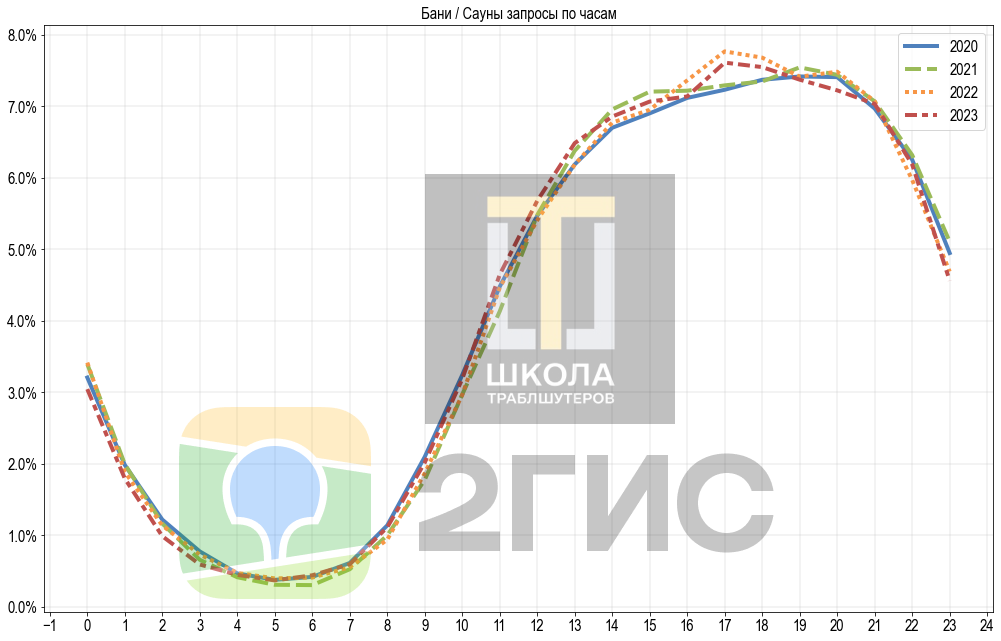

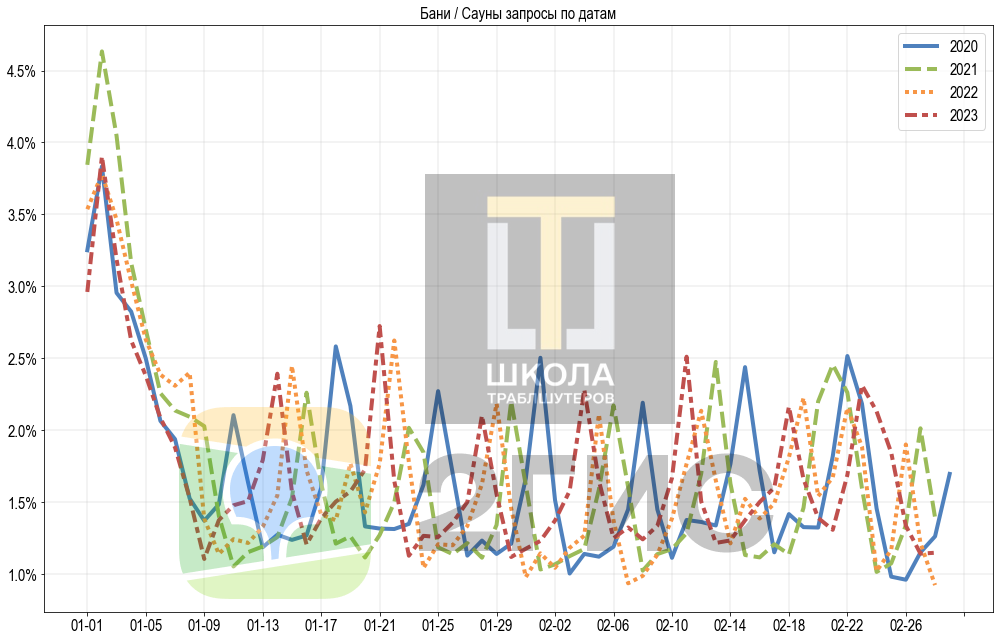

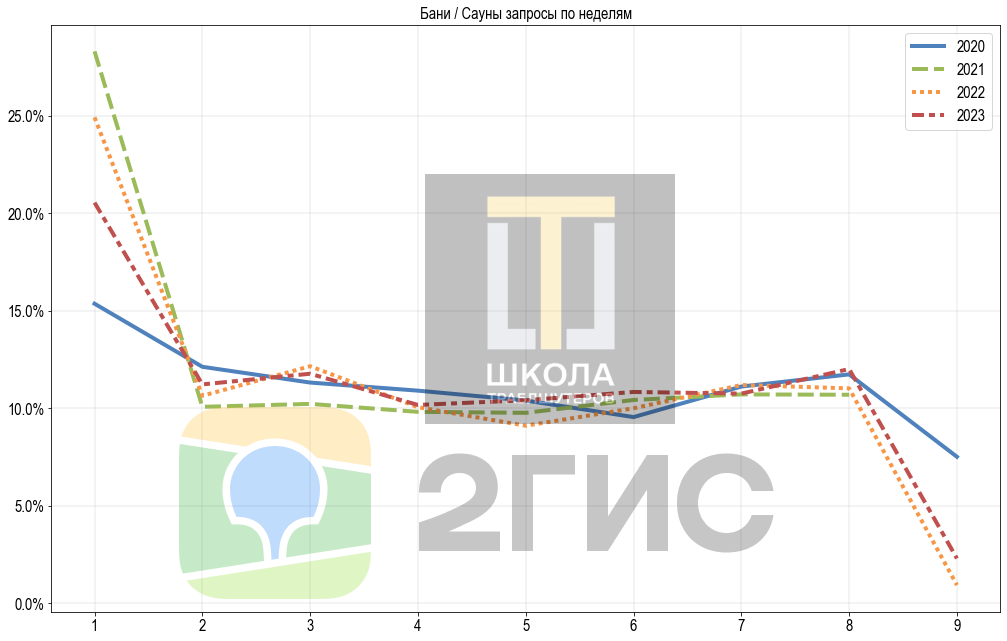

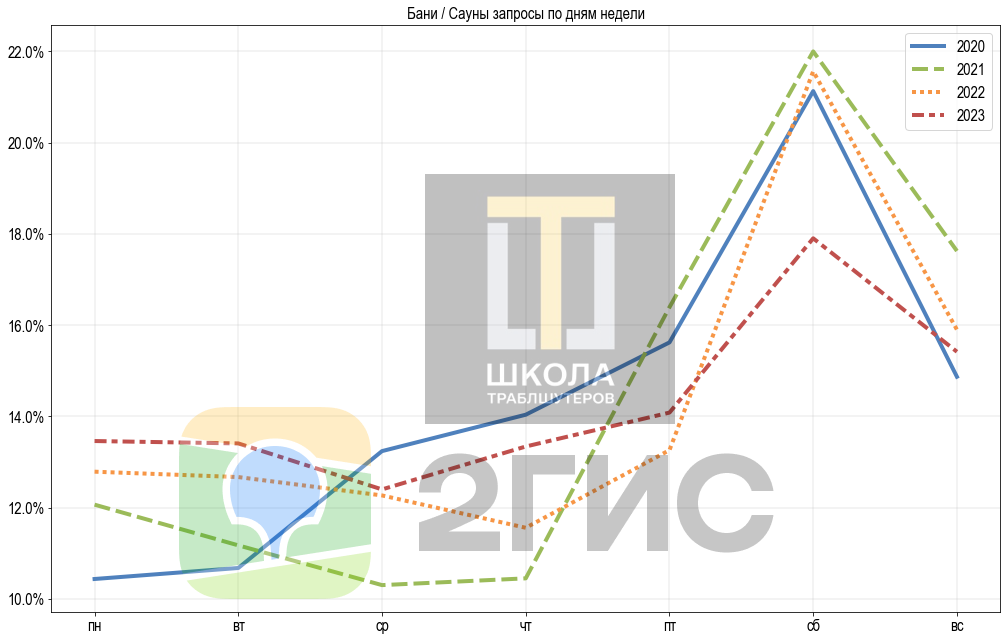

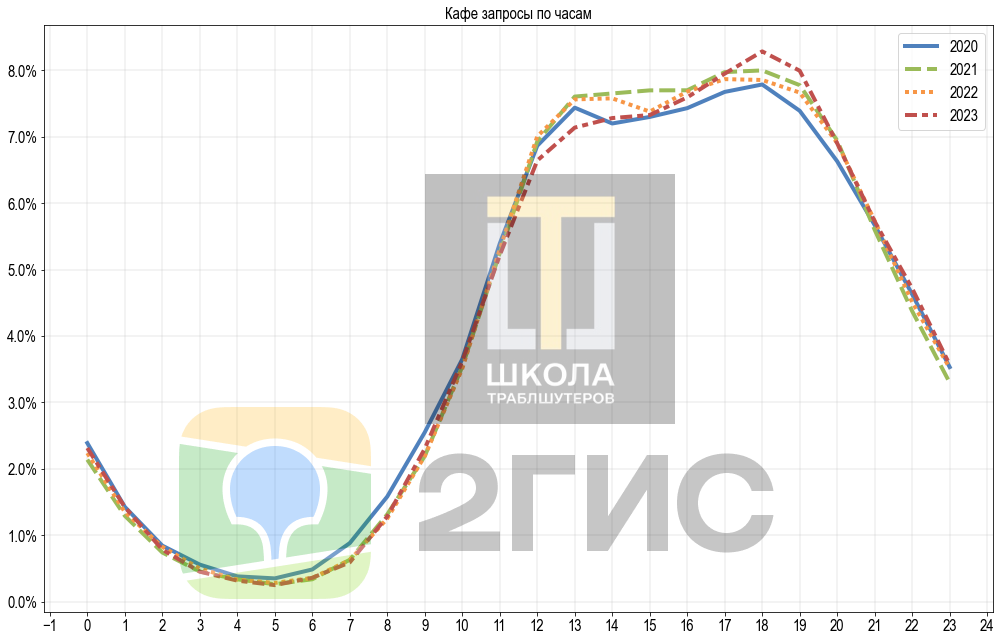

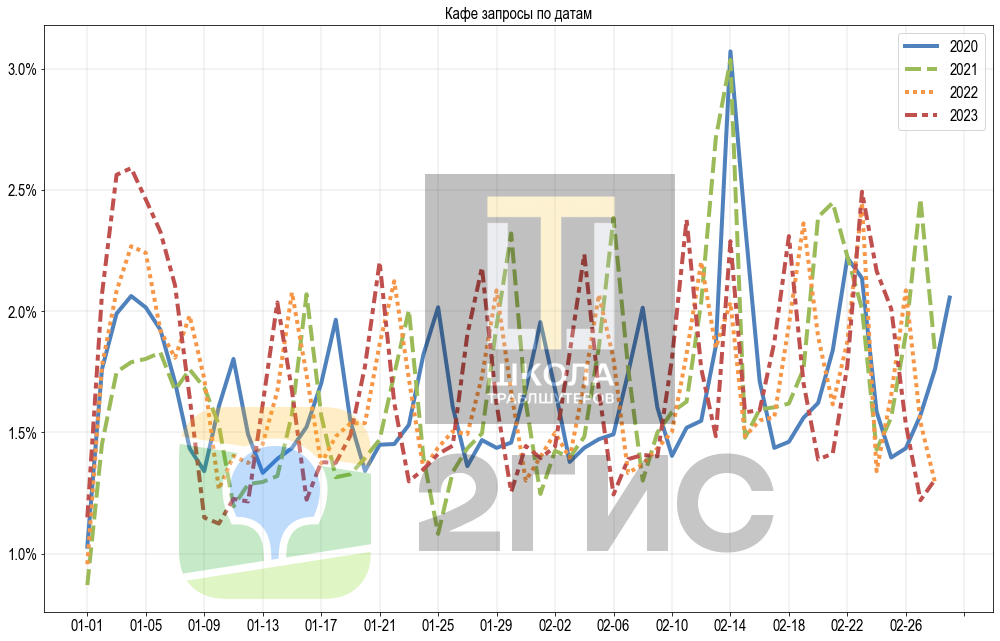

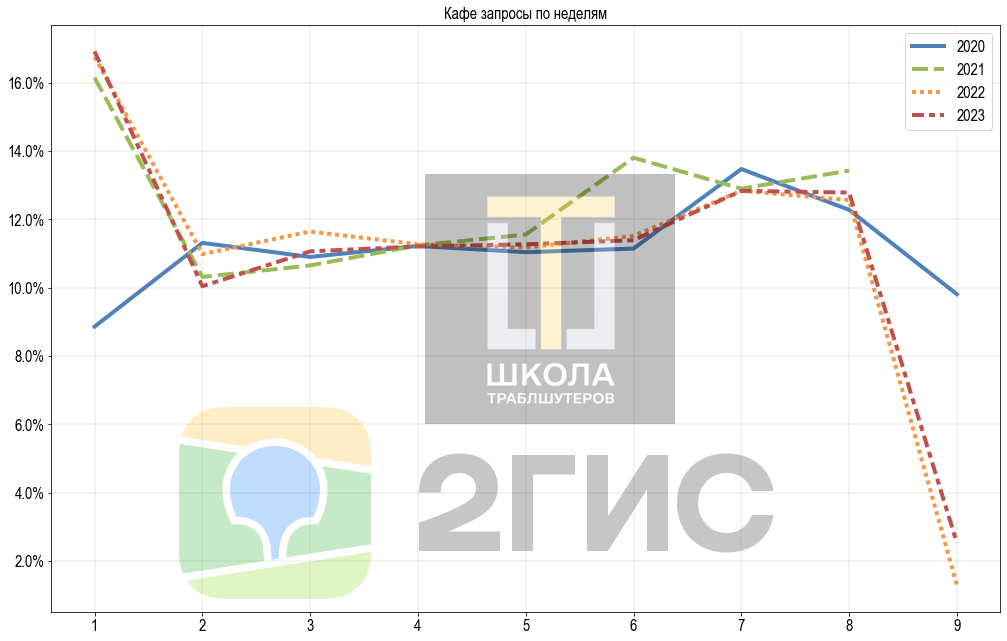

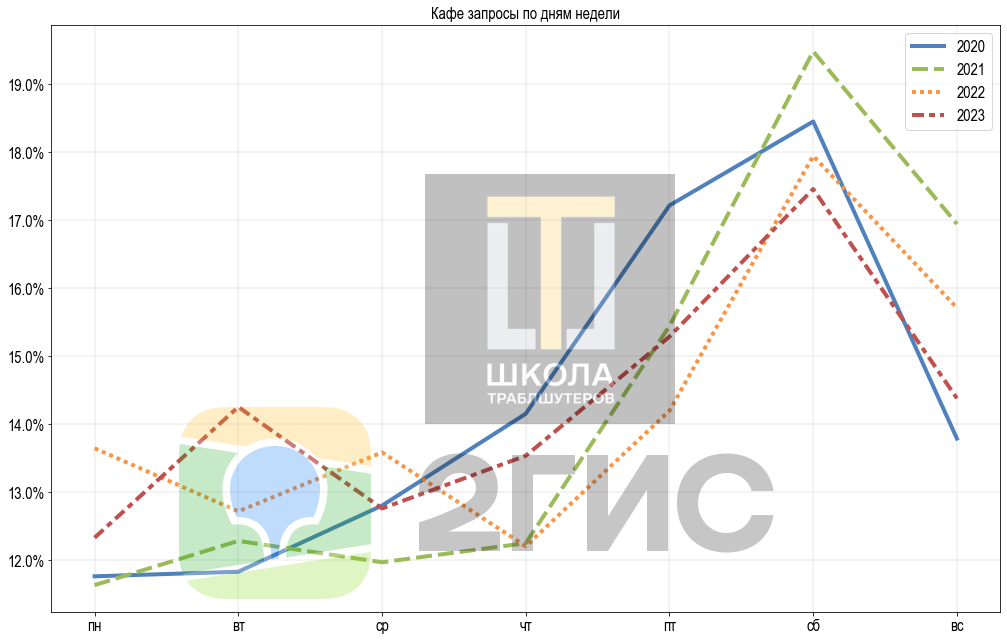

In [133]:
for rubric in rubrics[:].iloc[:,0].values[0:2]:
    dff1_test = dff1[dff1['Рубрика'] == rubric].set_index(dff1.columns[1])
    dff2_test = dff2[dff2['Рубрика'] == rubric].set_index(dff2.columns[1])
    dff3_test = dff3[dff3['Рубрика'] == rubric].set_index(dff3.columns[1])
    dff4_test = dff4[dff4['Рубрика'] == rubric].set_index(dff4.columns[1])
    dff4_test.index = (['пн','вт','ср','чт','пт','сб','вс'])
    
    for d in [dff1_test, dff2_test, dff3_test, dff4_test]:
        ax = sns.lineplot(data = d, linewidth=4, palette=['#4F81BD', '#9BBB59', '#F79646', '#C0504D'])
        plt.rcParams['figure.figsize']=17,10.8
        plt.rcParams['font.size'] = '16'
        fpath = Path(mpl.get_data_path(), r"C:\Users\Mamed\Downloads\arialnarrow.ttf")
        plt.legend(['2020', '2021', '2022', '2023'], prop=fpath)
        plt.xticks(font=fpath)
        plt.yticks(font=fpath)
        plt.grid(visible=True, linewidth=0.3)
        ax.set_xlabel('')
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}%'))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) 
        if 'Час' == d.index.name:
            ax.set_title(rubric + ' запросы по часам', font=fpath)
        elif 'Дата' == d.index.name:
            ax.xaxis.set_major_locator(ticker.MultipleLocator(4)) 
            ax.set_title(rubric + ' запросы по датам', font=fpath)
        elif 'Неделя' == d.index.name:
            ax.set_title(rubric + ' запросы по неделям', font=fpath)
        else:
            ax.set_title(rubric + ' запросы по дням недели', font=fpath)
            
        im = plt.imread(r"C:\Users\Mamed\Downloads\250x250bb.jpg")
        ax.figure.figimage(im,
                           ax.bbox.xmax//2 - im.shape[0]//2,
                           ax.bbox.ymax//2 - im.shape[1]//2,
                           alpha=.25, zorder=1)
        im = plt.imread(r"C:\Users\Mamed\Downloads\ebf33342-98a0-4d36-8d90-a432d9bcf456.png")
        ax.figure.figimage(im,
                           ax.bbox.xmax//4 - im.shape[0]//2,
                           ax.bbox.ymax//2 - im.shape[1]//2,
                           alpha=.25, zorder=1)
        plt.show()